In [1]:
###Importing the modules###

import numpy as np
import xarray as xr
import math as mt
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import glob
from metpy.plots import USCOUNTIES
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats
from collections import Counter
import cftime

print("Done importing modules")

Done importing modules


In [2]:
###Create map background function###

def create_basemap():
    
    #Set up the projection that will be used#
    mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
    mapcrs = ccrs.PlateCarree()
    datacrs = ccrs.PlateCarree()

    #Add geopolitical boundaries for map reference#
    ax1.add_feature(cfeature.LAND, facecolor="white") 
    countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
    ax1.add_feature(countries, linewidth=0.5, edgecolor="black") 
    ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
    ax1.coastlines('50m', linewidth=0.8)


In [3]:
###Plot statistics###

def statistics(T_Array):
    '''This function computes 6 basic stats 
     for a given temperature array'''
    
    mean = np.nanmean(T_Array)
    stdv = np.std(T_Array)
    sigma_1_r = mean + stdv
    sigma_1_l = mean - stdv
    sigma_2_r = mean + 2*stdv
    sigma_2_l = mean - 2*stdv
    
    return (mean, stdv, sigma_1_r, sigma_1_l, sigma_2_r, sigma_2_l)

In [4]:
###Obtain ERA5 3hr data now###

ERA5_directory = "/pl/active/ATOC_SynopticMet/Michael/Old/ERA5_annualdata/"

#Specify the file pattern with a wildcard for the year and use glob to sort#
era5_directory = "/pl/active/ATOC_SynopticMet/Michael/Old/ERA5_annualdata/"
input_files = sorted(glob.glob(ERA5_directory+"era5_colorado_3hr_*.nc"))

#Initialize an empty list to store individual datasets#
datasets = []

#Loop through the list of input files and open each one#
for input_file in input_files:
    ds = xr.open_dataset(input_file)
    datasets.append(ds)

#Concatenate the list of datasets along the 'time' dimension#
ds_era5 = xr.concat(datasets, dim='time')
ds_era5

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 25, time: 213304)
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.8 -109.5 ... -101.5 -101.2 -101.0
  * latitude   (latitude) float32 42.0 41.75 41.5 41.25 ... 36.5 36.25 36.0
  * time       (time) datetime64[ns] 1950-01-01 ... 2022-12-31T21:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 263.5 263.7 ... 271.3 271.4
    t2m        (time, latitude, longitude) float32 264.8 264.8 ... 290.7 290.0
    sp         (time, latitude, longitude) float32 7.97e+04 ... 9.016e+04
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-09 04:16:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
###Add in derived variables along with ThetaE###

#Temp, dewpoint, and sfc pressure#
ds_era5['tempf'] = (ds_era5['t2m'] - 273.15) * 9/5 + 32
ds_era5['dewf'] = (ds_era5['d2m'] - 273.15) * 9/5 + 32
ds_era5['sp_hPa'] = (ds_era5['sp'] / 100) 

##########################################################

#ThetaE#
temperature_full = ds_era5['t2m'].values * units.kelvin
dewpoint_full = ds_era5['d2m'].values * units.kelvin
pressure_full = ds_era5['sp_hPa'].values * units.hPa  

#Calculate the equivalent potential temperature#
theta_e_full = mpcalc.equivalent_potential_temperature(pressure_full, temperature_full, dewpoint_full)

#Convert theta_e from a MetPy Quantity to a numpy array#
theta_e_array_full = theta_e_full.magnitude

#Create a new xarray DataArray for ThetaE with right dimensions#
theta_e_data_array_xr = xr.DataArray(data=theta_e_array_full, 
                                  dims=["time", "latitude", "longitude"],
                                  coords={"time": ds_era5.time, 
                                          "latitude": ds_era5.latitude, 
                                          "longitude": ds_era5.longitude},
                                  attrs={'units': 'K', 'long_name': 'Equivalent Potential Temperature'})

#Add it back as a data variable#
ds_era5['thetaE'] = theta_e_data_array_xr

ds_era5

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 25, time: 213304)
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.8 -109.5 ... -101.5 -101.2 -101.0
  * latitude   (latitude) float32 42.0 41.75 41.5 41.25 ... 36.5 36.25 36.0
  * time       (time) datetime64[ns] 1950-01-01 ... 2022-12-31T21:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 263.5 263.7 ... 271.3 271.4
    t2m        (time, latitude, longitude) float32 264.8 264.8 ... 290.7 290.0
    sp         (time, latitude, longitude) float32 7.97e+04 ... 9.016e+04
    tempf      (time, latitude, longitude) float32 16.93 17.03 ... 63.63 62.38
    dewf       (time, latitude, longitude) float32 14.62 14.92 ... 28.74 28.78
    sp_hPa     (time, latitude, longitude) float32 797.0 798.2 ... 897.2 901.6
    thetaE     (time, latitude, longitude) float32 289.2 289.3 ... 311.4 310.1
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-09 04:16:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
###Convert time from UTC to MST or MDT###

#Step 1: Convert the time coordinate to a pandas datetime index#
time_index = pd.DatetimeIndex(ds_era5['time'].values)

#Step 2: Localize the datetime index to UTC#
time_index_utc = time_index.tz_localize('UTC')

#Step 3: Convert the localized datetime index to Mountain Time#
time_index_mountain = time_index_utc.tz_convert('America/Denver')  

#Step 4: Replace the dataset's time coordinate with the converted datetime index#
ds_era5['time'] = time_index_mountain

#Remove timezone information#
time_index_naive = time_index_mountain.tz_localize(None)

#Assign the timezone-naive index back to the dataset#
ds_era5['time'] = time_index_naive

ds_era5

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 25, time: 213304)
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.8 -109.5 ... -101.5 -101.2 -101.0
  * latitude   (latitude) float32 42.0 41.75 41.5 41.25 ... 36.5 36.25 36.0
  * time       (time) datetime64[ns] 1949-12-31T17:00:00 ... 2022-12-31T14:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 263.5 263.7 ... 271.3 271.4
    t2m        (time, latitude, longitude) float32 264.8 264.8 ... 290.7 290.0
    sp         (time, latitude, longitude) float32 7.97e+04 ... 9.016e+04
    tempf      (time, latitude, longitude) float32 16.93 17.03 ... 63.63 62.38
    dewf       (time, latitude, longitude) float32 14.62 14.92 ... 28.74 28.78
    sp_hPa     (time, latitude, longitude) float32 797.0 798.2 ... 897.2 901.6
    thetaE     (time, latitude, longitude) float32 289.2 289.3 ... 311.4 310.1
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-09 04:16:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
# ###Plot Disagreement days in the fronts###

# date2plot = '1987-12-09T17'

# #Extract variables#
# temp_day1 = ds_era5['tempf'].sel(time=date2plot)  #,method='nearest'
# eptemp_day1 = ds_era5['thetaE'].sel(time=date2plot)
# lons_era5 = ds_era5['longitude']
# lats_era5 = ds_era5['latitude']

# #Set up the projection that will be used#
# mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
# mapcrs = ccrs.PlateCarree()
# datacrs = ccrs.PlateCarree()

# #Start the figure and create plot axes with proper projection#
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax1.set_extent([-110, -101, 36, 42], ccrs.PlateCarree())
# ax2.set_extent([-110, -101, 36, 42], ccrs.PlateCarree())

# #Add geopolitical boundaries for map reference#
# ax1.add_feature(cfeature.LAND, facecolor="white") 
# countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
# ax1.add_feature(countries, linewidth=0.5, edgecolor="black") 
# ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
# ax1.coastlines('50m', linewidth=0.8)
# ax2.add_feature(cfeature.LAND, facecolor="white") 
# countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
# ax2.add_feature(countries, linewidth=0.5, edgecolor="black") 
# ax2.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
# ax2.coastlines('50m', linewidth=0.8)

# #Calculate colorbar levels#
# floor_T = np.floor(np.nanmin(temp_day1))
# ceil_T = np.ceil(np.nanmax(temp_day1)+1)
# clevels_T = np.arange(floor_T, ceil_T, 1)

# floor_ThE = np.floor(np.nanmin(eptemp_day1))
# ceil_ThE = np.ceil(np.nanmax(eptemp_day1)+1)
# clevels_ThE = np.arange(floor_ThE, ceil_ThE, 1)

# #Plot the temperature, thetae data, and add colorbar#
# im1 = ax1.contourf(lons_era5, lats_era5, temp_day1, levels=clevels_T, cmap='coolwarm', origin='lower')  #plot
# im2 = ax2.contourf(lons_era5, lats_era5, eptemp_day1, levels=clevels_ThE, cmap='coolwarm', origin='lower')  #plot
# cbar1 = plt.colorbar(im1, ax=ax1, label='Temperature (F)')
# cbar2 = plt.colorbar(im2, ax=ax2, label='ThetaE (K)')

# #Plot BKF location#
# ax1.plot(-104.7579, 39.7025, marker='*', markersize=14, markerfacecolor='yellow', markeredgecolor='black')
# ax1.text(-104.7579, 39.7025, 'BKF', fontsize=14)

# ax2.plot(-104.7579, 39.7025, marker='*', markersize=14, markerfacecolor='yellow', markeredgecolor='black')
# ax2.text(-104.7579, 39.7025, 'BKF', fontsize=14)

# #Set axis labels and title#
# ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Latitude')
# ax1.set_title(f'ERA5 Tmax Front Day on {date2plot}', fontsize=14)
# ax1.set_xticks(range(-111, -99, 1), crs=ccrs.PlateCarree())
# ax1.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())

# ax2.set_xlabel('Longitude')
# ax2.set_ylabel('Latitude')
# ax2.set_title(f'ERA5 ThetaE Front Day on {date2plot}', fontsize=14)
# ax2.set_xticks(range(-111, -99, 1), crs=ccrs.PlateCarree())
# ax2.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())

# #plt.savefig("FD_1952_10_27.png", dpi=50)
# plt.show()

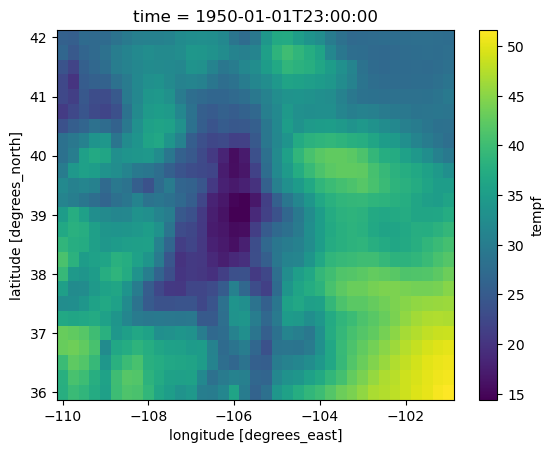

In [8]:
###Now mask out for only Eastern Colorado Area###

#Define bounds for eastern Colorado#
lon_min = -105.35
lon_max = -102
lat_min = 37
lat_max = 41

#Easiest way to subset data#
ds_era5_sub = ds_era5.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))

#Test Plotting#
testing_grid = ds_era5['tempf'].isel(time=10)
testing_grid.plot()


In [9]:
###Calculate daily max at every gridpoint###

#Extract the temperature variable#
temperatures = ds_era5_sub['tempf']

#Compute daily maximum temperature for each grid point#
daily_maxes = temperatures.resample(time='D').max('time')

#Generate a new time coordinate with each day#
new_time_values = xr.cftime_range(start="1949-12-31", end="2022-12-31", freq='D')

#Assign the new time coordinate to your dataset#
daily_maxes['time'] = new_time_values

#Make the daily temps a new xarray variable for a new df#
ds_era5_subD = xr.Dataset({'Daily_Max_Temps': daily_maxes})

##Fix the time now with a shift##

#Now compute difference values # 
diffs = ds_era5_subD['Daily_Max_Temps'].diff(dim='time')

#Shift the differences by one along the time axis#
diffs_shifted = diffs.shift(time=1)

#Assign NaN to the first 2 days and very last days to exclude them#
diffs_shifted[0, :, :] = np.nan
diffs_shifted[-1, :, :] = np.nan

#Add the diffs_shifted to your dataset#
ds_era5_subD['Temp_Diffs'] = diffs_shifted

ds_era5_subD

<xarray.Dataset>
Dimensions:          (longitude: 14, latitude: 17, time: 26664)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) object 1949-12-31 00:00:00 ... 2022-12-31 00:00:00
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 34.37 35.72 ... 64.19
    Temp_Diffs       (time, latitude, longitude) float32 nan nan nan ... nan nan

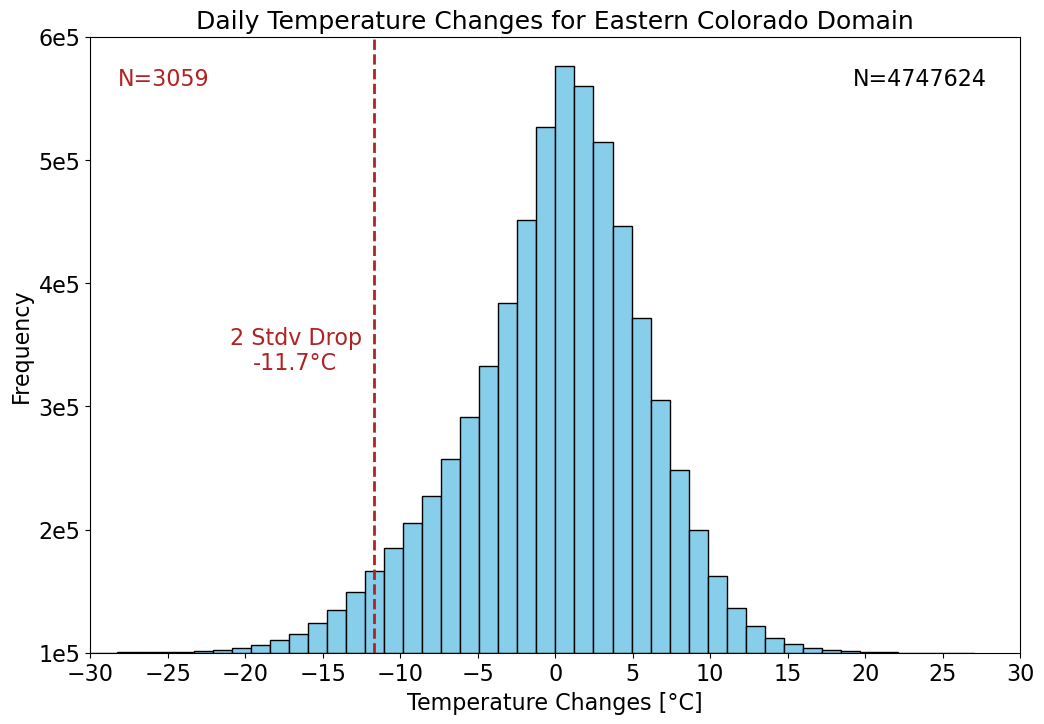

-0.017568836
5.8332744


In [10]:
###Plot a histogram of the flattened Max Temp. Drops###

#Find the diffs#
temp_diffs = ds_era5_subD.sel(time=~ds_era5_subD['time'].dt.month.isin([6, 7, 8]))
flattened_diffs = temp_diffs['Temp_Diffs'].values.flatten()

#Convert to celsius#
flattened_diffs_C = flattened_diffs * 0.55555556

#Plotting#
plt.figure(figsize=(12, 8))
plt.hist(flattened_diffs_C, bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Temperature Changes [°C]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Daily Temperature Changes for Eastern Colorado Domain', fontsize=18)
plt.xticks(np.arange(-30,40,5))
plt.xlim([-30,30])
#plt.ylim([0,60])
plt.yticks(np.arange(0,6e5,1e5),['1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
plt.axvline(np.nanstd(flattened_diffs_C) * -2, color='firebrick', linestyle='dashed', linewidth=2)

plt.text(-21, 250000, '2 Stdv Drop', color='firebrick', fontsize=16)
plt.text(-19.5, 230000, '-11.7°C', color='firebrick', fontsize=16)  #~ -21°F

plt.text(0.82, 0.95, f'N={len(flattened_diffs)}', transform=plt.gca().transAxes,
         fontsize=16, verticalalignment='top')  #bbox=dict(boxstyle="square", facecolor="white")
plt.text(0.03, 0.95, 'N=3059', transform=plt.gca().transAxes,
         fontsize=16, color='firebrick', verticalalignment='top')  #bbox=dict(boxstyle="square", facecolor="white")
plt.tick_params(labelsize=16)

#plt.savefig("DTDrops_C.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

print(np.nanmean(flattened_diffs_C))
print(np.nanstd(flattened_diffs_C))

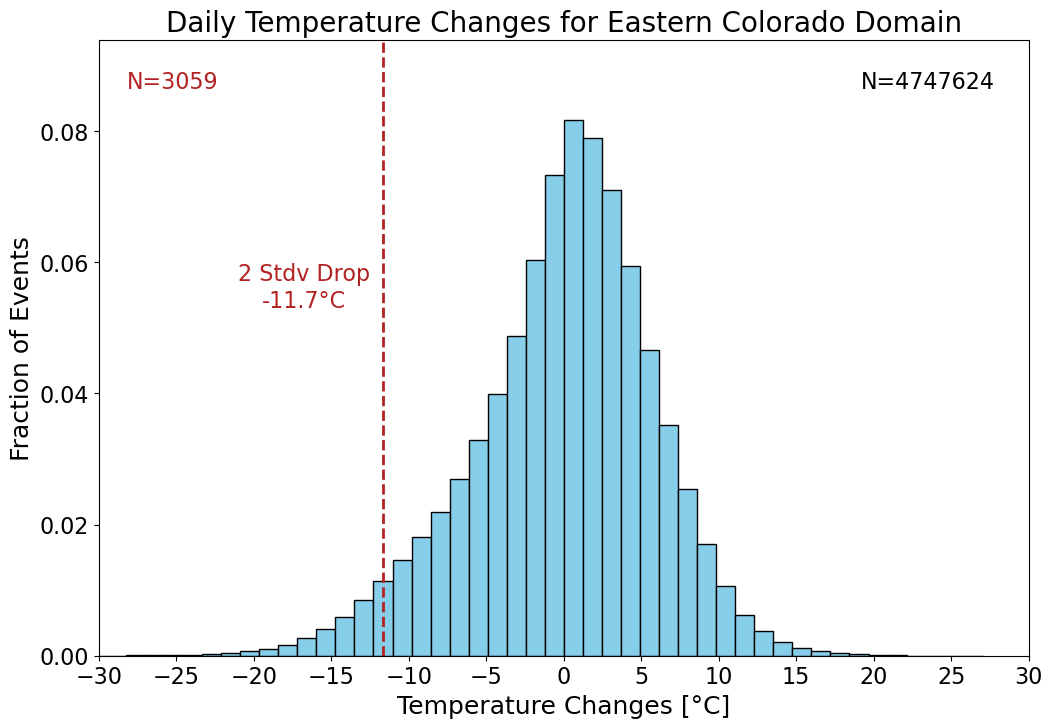

In [11]:
###Plotting as relative frequency (%)###

plt.figure(figsize=(12, 8))

#Histogram using density=True for relative frequency#
counts, bins, patches = plt.hist(flattened_diffs_C, bins=50, density=True,
                                  color='skyblue', edgecolor='black')

#Convert density to % (probability density × 100)#
bin_width = bins[1] - bins[0]
plt.ylim(0, np.max(counts)*1.15)  # Optional: adjust y-limits

plt.xlabel('Temperature Changes [°C]', fontsize=18)
plt.ylabel('Fraction of Events', fontsize=18)
plt.title('Daily Temperature Changes for Eastern Colorado Domain', fontsize=20)

#Add vertical line for 2 std dev#
plt.axvline(np.nanstd(flattened_diffs_C) * -2, color='firebrick', linestyle='dashed', linewidth=2)

plt.text(-21, np.max(counts)*0.7, '2 Stdv Drop', color='firebrick', fontsize=16)
plt.text(-19.5, np.max(counts)*0.65, '-11.7°C', color='firebrick', fontsize=16)

#Show total sample size#
plt.text(0.82, 0.95, f'N={len(flattened_diffs)}', transform=plt.gca().transAxes,
         fontsize=16, verticalalignment='top')
plt.text(0.03, 0.95, 'N=3059', transform=plt.gca().transAxes,
         fontsize=16, color='firebrick', verticalalignment='top')

#Ticks and axis limits#
plt.xticks(np.arange(-30, 40, 5))
plt.xlim([-30, 30])
plt.tick_params(labelsize=16)

plt.savefig("DTDrops_C_Freq.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()


In [12]:
###Now make a binary mask where 0 is below threshold and 1 is above threshold for daily T drop###

#Initialize new flag var#
ds_era5_subD['Temp_Drop_Flag'] = (('time', 'latitude', 'longitude'), np.zeros_like(ds_era5_subD['Temp_Diffs']))

#Apply threshold#
threshold = np.nanstd(flattened_diffs) * -2
ds_era5_subD['Temp_Drop_Flag'] = xr.where(ds_era5_subD['Temp_Diffs'] < threshold, 1, 0)
ds_era5_subD

<xarray.Dataset>
Dimensions:          (longitude: 14, latitude: 17, time: 26664)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) object 1949-12-31 00:00:00 ... 2022-12-31 00:00:00
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 34.37 35.72 ... 64.19
    Temp_Diffs       (time, latitude, longitude) float32 nan nan nan ... nan nan
    Temp_Drop_Flag   (time, latitude, longitude) int64 0 0 0 0 0 0 ... 0 0 0 0 0

In [13]:
###Import the T52 mask and the elevation data###

#Get the T52 area#
binmask = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/binary_mask_T52.nc')
binmask

#Get the elevation data and process it#
#ERA5 terrain stuff with geopotential#
input_elv = 'Other_Data/terrain_0.1.nc'
df_elevation = xr.open_dataset(input_elv)
#df_elevation['z'].plot()

#Define bounds for all of Colorado#
lon_min = 251  
lon_max = 258   
lat_min = 37
lat_max = 41

#Slice out the array and convert to height [m]# 
df_ele_CO = df_elevation.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
heights = (df_ele_CO['z'][0,:,:].values) / 9.81
heights

array([[2427.43552539, 2442.79487629, 2322.68475226, ..., 1086.97377454,
        1082.87794764, 1072.5359847 ],
       [2150.55762651, 2193.25662201, 2148.40731738, ..., 1122.50507296,
        1107.7600961 , 1090.04564472],
       [2022.15345299, 1984.67663679, 1965.73343735, ..., 1141.4482724 ,
        1117.79487202, 1093.32230625],
       ...,
       [1606.22223063, 1753.26241657, 1869.68629639, ..., 1170.63103911,
        1132.23266186, 1099.67083796],
       [1478.02284845, 1580.62331246, 1687.62679039, ..., 1147.18243007,
        1113.28946242, 1089.84085338],
       [1445.97300291, 1473.10785616, 1539.97223041, ..., 1142.26743778,
        1120.8667422 , 1104.89301726]])

In [14]:
rand_levs = np.array([0,1])
rand_levs

array([0, 1])

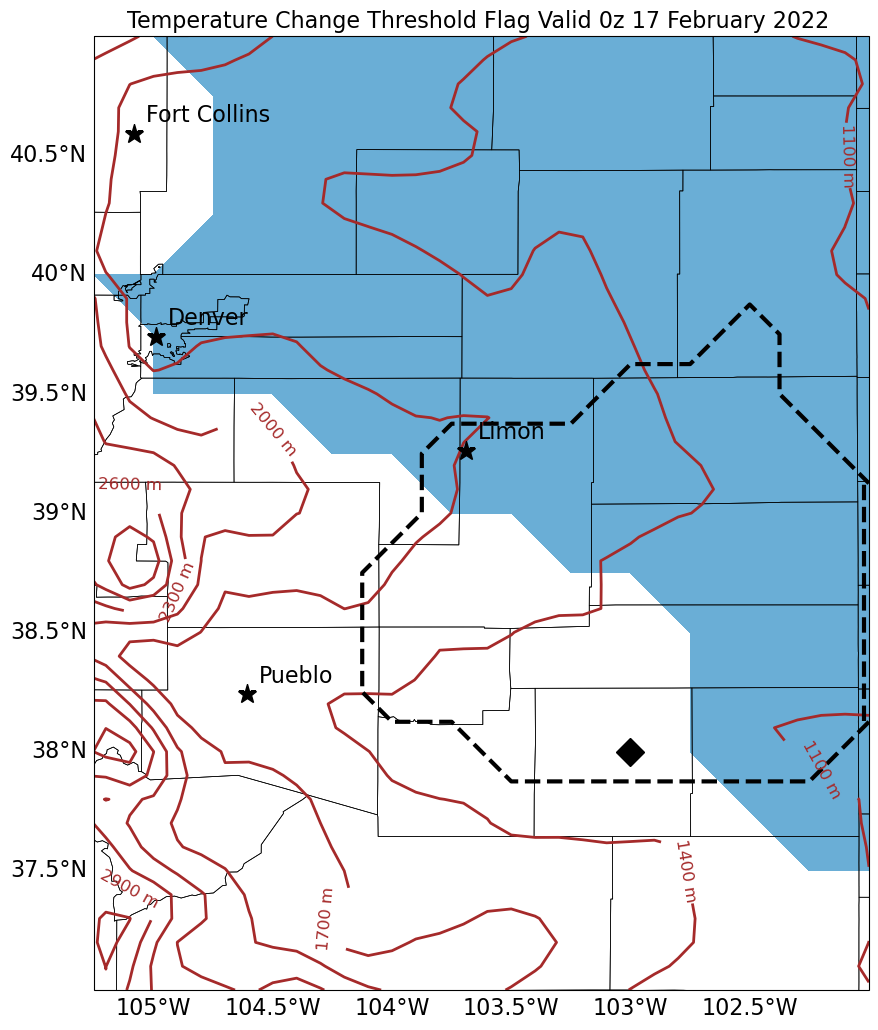

In [15]:
###Select the days and plot a day###

#Filter out the 1 tag#
days_with_drops = ds_era5_subD['Temp_Drop_Flag'].sum(dim=['latitude', 'longitude'])
days_of_interest = days_with_drops[days_with_drops > 0].time
#print(days_of_interest.values)
#print(len(days_of_interest.values))

#Get data by sel a day#
rand_day = '2022-02-17T00:00:00'  #Example date
data_of_interest = ds_era5_subD['Temp_Drop_Flag'].sel(time=rand_day)

#Define the extent to tightly fit the data area#
lons = ds_era5_subD['longitude'].values
lats = ds_era5_subD['latitude'].values
lon_min, lon_max = np.min(lons), np.max(lons)
lat_min, lat_max = np.min(lats), np.max(lats)

#Plotting#
masked_dataOI = np.ma.masked_where(data_of_interest != 1, data_of_interest)
rand_levs = [0, 1]
fig, ax = plt.subplots(1, figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(data_of_interest.longitude, data_of_interest.latitude, masked_dataOI[0,:,:], levels=rand_levs, cmap='Blues', transform=ccrs.PlateCarree(), extend='neither')

#Plot the elevation spatial data#
clevels = np.arange(800, 4000, 300)
im2 = ax.contour(df_ele_CO['longitude'], df_ele_CO['latitude'], heights, levels=clevels, colors='brown', origin='lower', linewidths=2)

plt.clabel(im2, inline=True, fontsize=12, fmt="%.0f m")

#Plot the T52 regions#
binmask_data = binmask['binary_mask_tcf'].values
im3 = ax.contour(lons, lats, binmask_data, levels=[0.5], colors='black', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=14, color='black', transform=ccrs.PlateCarree()) 

#Add vertical line at the eastern edge of T52 region (CO/KS border)#
T52_east_edge = -102.02  # adjust if needed
ax.plot([T52_east_edge, T52_east_edge], [38.13, 39.14],
        color='black', linewidth=3, linestyle='dashed',
        transform=ccrs.PlateCarree(), zorder=5)

#Colorbar#
#cbar = fig.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
#cbar.set_label('Temp_Drop_Flag')
#cbar.set_ticks([-1,0,1])
#cbar.set_label(label='Temperature Change Threshold Flag', size=14)
#cbar.ax.tick_params(labelsize=14)
plt.title('Temperature Change Threshold Flag Valid 0z 17 February 2022 ', fontsize=16)
#plt.title('Eastern Colorado Study Domain', fontsize=18)

#Plot some cities#
cities = {
    "Denver": (-104.99, 39.74),
    "Limon": (-103.69, 39.26),
    "Pueblo": (-104.61, 38.24),
    "Fort Collins": (-105.08, 40.59)
}

for city, (lon, lat) in cities.items():
    plt.plot(lon, lat, marker='*', markersize=14, markerfacecolor='black', markeredgecolor='black', transform=ccrs.PlateCarree())
    plt.text(lon + 0.05, lat + 0.05, city, color='black', fontsize=16, transform=ccrs.PlateCarree())

#Add county borders#
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)

#Set the extent to only show the area with data#
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#Add gridlines and labels for latitude and longitude#
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='none')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}

#plt.savefig("Randday.png", dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

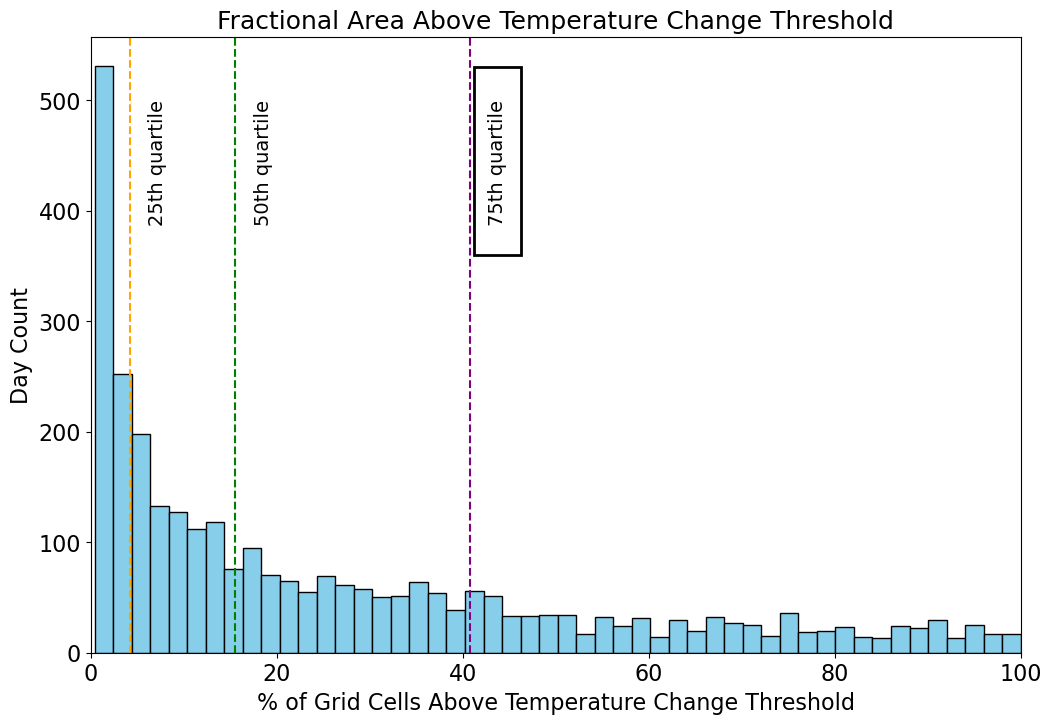

4.201680672268908 15.546218487394958 40.7563025210084
Number of days: 763 above 40.7563025210084 cells flagged=1


In [16]:
###Plot a PDF of 1 flag counts###
import matplotlib.patches as patches

#Sum up the 'Temp_Drop_Flag' over latitude and longitude for each day#
daily_counts_flag = ds_era5_subD['Temp_Drop_Flag'].sum(dim=['latitude', 'longitude'])

#Normalize and filter out 0 flagged days#
total_grid_cells = 238
normalized_daily_counts = [(count/total_grid_cells) * 100 for count in daily_counts_flag]
filtered_daily_counts = [count for count in normalized_daily_counts if count > 0]

#Plot the figure#
plt.figure(figsize=(12,8))
plt.hist(filtered_daily_counts, color='skyblue', bins=50, edgecolor='black')
plt.xlabel('% of Grid Cells Above Temperature Change Threshold', fontsize=16)
plt.ylabel('Day Count', fontsize=16)
#plt.ylim([0, 500])
plt.xlim([0, 100])
plt.title('Fractional Area Above Temperature Change Threshold', fontsize=18)

#Find %iles#
q25 = np.percentile(filtered_daily_counts, 25)
q50 = np.percentile(filtered_daily_counts, 50)
q75 = np.percentile(filtered_daily_counts, 75)

#Plotting vertical lines for quartiles and annotating them#
plt.axvline(q25, color='orange', linestyle='--', label=f'25th percentile: {q25:.2f}%')
plt.axvline(q50, color='green', linestyle='--', label=f'50th percentile: {q50:.2f}%')
plt.axvline(q75, color='purple', linestyle='--', label=f'75th percentile: {q75:.2f}%')
plt.text(q25+3, plt.ylim()[1]*0.7, f'25th quartile', color='black', fontsize=14, rotation=90, ha='center')
plt.text(q50+3, plt.ylim()[1]*0.7, f'50th quartile', color='black', fontsize=14, rotation=90, ha='center')
plt.text(q75+3, plt.ylim()[1]*0.7, f'75th quartile', color='black', fontsize=14, rotation=90, ha='center')
plt.tick_params(labelsize=16)
#plt.yscale('log')

#Draw box around q75#
rect = patches.Rectangle((q75+0.5, 360), 5, 170, linewidth=2, edgecolor='black', facecolor='none')
plt.gca().add_patch(rect)

#plt.savefig("Frac_Area_Above.png", dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(q25, q50, q75)

#Find number of cases above q75#
days_above_threshold_fr = sum(1 for count in filtered_daily_counts if count > q75)
print(f"Number of days: {days_above_threshold_fr} above {q75} cells flagged=1")

#plt.savefig("75_Threshold.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()


In [17]:
###Filter out days that are above q75 with ~41% coverage, and exclude JJA and add it back to xarray datset###

#Recalculate 75th percentile value#
q75_fr = np.percentile(days_with_drops[days_with_drops > 0], 75)  #can change

#Now filter the days_of_interest to get only those days where the count is above q75#
days_above_q75 = days_with_drops.where(days_with_drops > q75_fr, drop=True).time  

#Print the filtered dates and their count#
print(len(days_above_q75.values))

#Initialize and flag all days as 1 in big datarray#
cold_front_flags = xr.full_like(ds_era5_subD['Temp_Drop_Flag'].isel(latitude=0, longitude=0), 0)

for day in days_above_q75.values:
    cold_front_flags.loc[dict(time=day)] = 1

#Assign this array to a new variable in your dataset#
ds_era5_subD['Cold_Front_Days'] = cold_front_flags
ds_era5_subD

763


<xarray.Dataset>
Dimensions:          (longitude: 14, latitude: 17, time: 26664)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) object 1949-12-31 00:00:00 ... 2022-12-31 00:00:00
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 34.37 35.72 ... 64.19
    Temp_Diffs       (time, latitude, longitude) float32 nan nan nan ... nan nan
    Temp_Drop_Flag   (time, latitude, longitude) int64 0 0 0 0 0 0 ... 0 0 0 0 0
    Cold_Front_Days  (time) int64 0 0 0 0 1 0 0 0 0 0 0 ... 0 1 0 0 0 0 0 0 0 0

In [18]:
###Function to add a rectangle around the max grid cell###

def add_max_frequency_rectangle(ax, data_array):

    max_idx = np.unravel_index(np.argmax(data_array.values), data_array.shape)

    lon = data_array.longitude[max_idx[1]]
    lat = data_array.latitude[max_idx[0]]

    d_lon = np.mean(np.diff(data_array.longitude.values)) / 2
    d_lat = np.mean(np.diff(data_array.latitude.values)) / 2

    rect = plt.Rectangle((lon - d_lon, lat - d_lat), 2 * d_lon, 2 * d_lat, 
                         linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

/tmp/ipykernel_2212622/2320718090.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  heatmap = plt.contourf(cold_front_frequency.longitude, cold_front_frequency.latitude, cold_front_frequency_p, levels=CFF_levels_p, cmap='viridis', shading='auto')


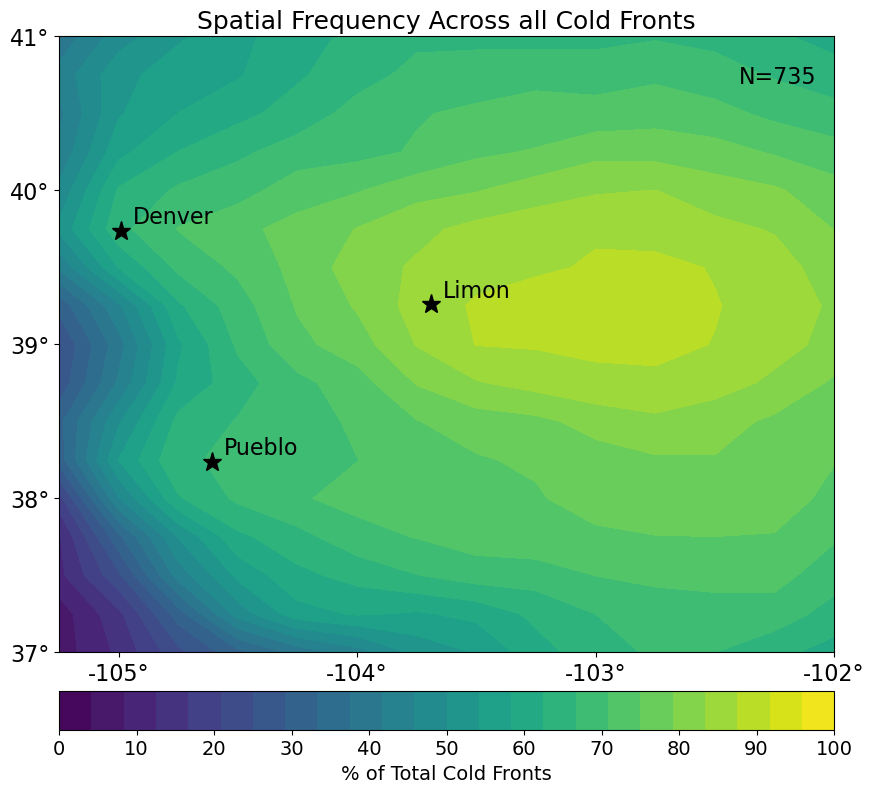

In [19]:
###Plot a heatmap of the grid cells###

#Filter out June, July, and August from the dataset#
not_summer = ds_era5_subD.sel(time=~ds_era5_subD['time'].dt.month.isin([6, 7, 8]))

#First, we create a mask from the Cold_Front_Days - days marked '1' are our cold front days#
cold_front_mask = not_summer['Cold_Front_Days'] == 1

#Now, we apply this mask to the Temp_Drop_Flag to consider only the flagged points on cold front days#
cold_front_flags = not_summer['Temp_Drop_Flag'].where(cold_front_mask, drop=True)

#We sum these flags across the time dimension to get the frequency of flags for each grid cell#
cold_front_frequency = cold_front_flags.sum(dim='time')
cold_front_frequency_p = (cold_front_frequency / 735) * 100

#Plot heatmap#
#CFF_levels = np.arange(0,750, 25)
CFF_levels_p = np.linspace(0, 100, num=25)

plt.figure(figsize=(10, 10))
#heatmap = plt.contourf(cold_front_frequency.longitude, cold_front_frequency.latitude, cold_front_frequency, levels=CFF_levels, cmap='viridis', shading='auto')
heatmap = plt.contourf(cold_front_frequency.longitude, cold_front_frequency.latitude, cold_front_frequency_p, levels=CFF_levels_p, cmap='viridis', shading='auto')

cbar = plt.colorbar(heatmap, orientation='horizontal', pad=0.05)  #Frequency of Cold Front Flags
plt.title('Spatial Frequency Across all Cold Fronts', fontsize=18)
plt.tick_params(labelsize=16)
cbar.set_ticks(np.linspace(0, 100, num=11))
cbar.set_label(label='% of Total Cold Fronts', size=14)
cbar.ax.tick_params(labelsize=14)
plt.text(-102.4, 40.7, 'N=735', color='black', fontsize=16)

#Plot some cities

#Denver#
plt.plot(-104.99, 39.74, marker='*', markersize=14, markerfacecolor='black', markeredgecolor='black')
plt.text(-104.99+0.05, 39.74+0.05, 'Denver', color='black', fontsize=16)

# #Fort Collins#
# plt.plot(-105.08, 40.58, marker='*', markersize=14, markerfacecolor='black', markeredgecolor='black')
# plt.text(-105.08+0.05, 40.58+0.05, 'Fort Collins', color='black', fontsize=14)

# #Colorado Springs#
# plt.plot(-104.82, 38.83, marker='*', markersize=14, markerfacecolor='black', markeredgecolor='black')
# plt.text(-104.82+0.05, 38.83+0.05, 'Colorado Springs', color='black', fontsize=14)

#Pueblo#
plt.plot(-104.61, 38.24, marker='*', markersize=14, markerfacecolor='black', markeredgecolor='black')
plt.text(-104.61+0.05, 38.24+0.05, 'Pueblo', color='black', fontsize=16)

#Limon#
plt.plot(-103.69, 39.26, marker='*', markersize=14, markerfacecolor='black', markeredgecolor='black')
plt.text(-103.69+0.05, 39.26+0.05, 'Limon', color='black', fontsize=16)

#Add gridlines
#plt.grid(color='grey', linestyle='-', linewidth=0.6, alpha=0.5)
x_ticks = [-105, -104, -103, -102]
x_tick_labels = ['-105°', '-104°', '-103°', '-102°']
y_ticks = [37, 38, 39, 40, 41]
y_tick_labels = ['37°', '38°', '39°', '40°', '41°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

#plt.savefig("SV_ALL_CF.png", dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [20]:
##Create a new variable for my cold front dataset

#Make xarray data var#
ds_era5_subD['CF_Dataset'] = ds_era5_subD['Temp_Drop_Flag'].sel(time=days_above_q75)

#Exlcude JJA#
condition = ~ds_era5_subD['time'].dt.month.isin([6, 7, 8])
ds_era5_subD['CF_Dataset'] = ds_era5_subD['CF_Dataset'].where(condition, np.nan)
ds_era5_subD

<xarray.Dataset>
Dimensions:          (longitude: 14, latitude: 17, time: 26664)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) object 1949-12-31 00:00:00 ... 2022-12-31 00:00:00
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 34.37 35.72 ... 64.19
    Temp_Diffs       (time, latitude, longitude) float32 nan nan nan ... nan nan
    Temp_Drop_Flag   (time, latitude, longitude) int64 0 0 0 0 0 0 ... 0 0 0 0 0
    Cold_Front_Days  (time) int64 0 0 0 0 1 0 0 0 0 0 0 ... 0 1 0 0 0 0 0 0 0 0
    CF_Dataset       (time, latitude, longitude) float64 nan nan nan ... nan nan

In [21]:
###Import the real updated CF xr###

ds_era5_subD = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_723.nc')
#ds_era5_subD

CF_df_LP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_LP145.nc')
#CF_df_LP

CF_df_HP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_HP145.nc')
CF_df_LP

<xarray.Dataset>
Dimensions:          (time: 145, latitude: 17, longitude: 14)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) datetime64[ns] 1950-11-02 1950-12-27 ... 2022-11-11
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 ...
    Temp_Diffs       (time, latitude, longitude) float32 ...
    CF_Dataset       (time, latitude, longitude) float64 ...

Total non-NaN days: 723
80.33333333333333
Total non-NaN days: 145
Total non-NaN days: 145


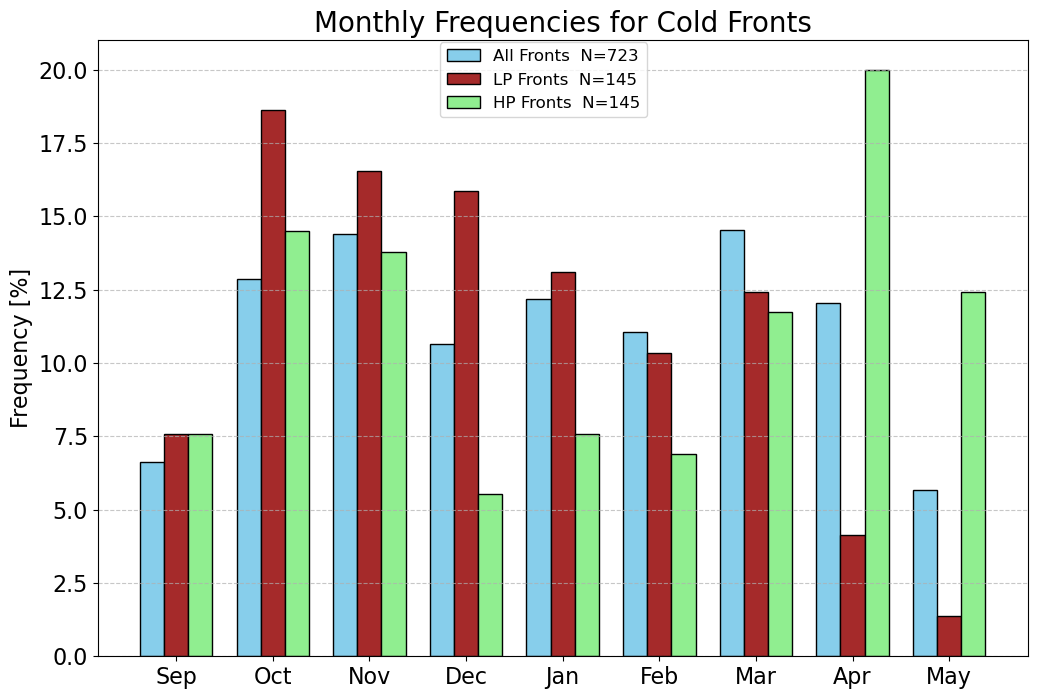

In [22]:
###Monthly frequencies of CF days###

#Extract non-nan days#
non_nan_days = ds_era5_subD['CF_Dataset'].notnull().any(dim=('latitude', 'longitude'))    #change the df here
non_nan_days = non_nan_days.where(non_nan_days, drop=True).time
print(f"Total non-NaN days: {len(non_nan_days)}")  #723 cases

#Extract the months from these days#
non_nan_months = non_nan_days.dt.month.values
non_nan_months_series = pd.Series(non_nan_months)

#Count the occurrences of each month#
monthly_counts = non_nan_months_series.value_counts().sort_index()
monthly_counts_reindexed = monthly_counts.reindex(range(1, 13), fill_value=0)
print(monthly_counts.mean())

#Filter out JJA#
cool_season_months = non_nan_months_series[~non_nan_months_series.isin([6, 7, 8])]

#Count the occurrences of each month and reindex to make sure all months are represented#
monthly_counts = cool_season_months.value_counts().sort_index()
cool_season_order = [9, 10, 11, 12, 1, 2, 3, 4, 5]  #September to May
monthly_counts_reindexed = monthly_counts.reindex(cool_season_order, fill_value=0)

#Find % frequencies instead of day counts for y-axis#
total_days = monthly_counts_reindexed.sum()
percent_frequency = (monthly_counts_reindexed / total_days) * 100

#***************
#LP Days#

#Extract non-nan days
non_nan_days2 = CF_df_LP['CF_Dataset'].notnull().any(dim=('latitude', 'longitude'))    #change the df here
non_nan_days2 = non_nan_days2.where(non_nan_days2, drop=True).time
print(f"Total non-NaN days: {len(non_nan_days2)}") #should be 880

#Step 2: Extract the months from these days#
non_nan_months2 = non_nan_days2.dt.month.values
non_nan_months_series2 = pd.Series(non_nan_months2)

#Filter out JJA#
cool_season_months2 = non_nan_months_series2[~non_nan_months_series2.isin([6, 7, 8])]

#Count the occurrences of each month and reindex to make sure all months are represented#
monthly_counts2 = cool_season_months2.value_counts().sort_index()
cool_season_order2 = [9, 10, 11, 12, 1, 2, 3, 4, 5]  #September to May
monthly_counts_reindexed2 = monthly_counts2.reindex(cool_season_order2, fill_value=0)

#Find % frequencies instead of day counts for y-axis#
total_days2 = monthly_counts_reindexed2.sum()
percent_frequency2 = (monthly_counts_reindexed2 / total_days2) * 100

#***************
#HP Days#

#Extract non-nan days
non_nan_days3 = CF_df_HP['CF_Dataset'].notnull().any(dim=('latitude', 'longitude'))    #change the df here
non_nan_days3 = non_nan_days3.where(non_nan_days3, drop=True).time
print(f"Total non-NaN days: {len(non_nan_days3)}") #should be 880

#Step 2: Extract the months from these days#
non_nan_months3 = non_nan_days3.dt.month.values
non_nan_months_series3 = pd.Series(non_nan_months3)

#Filter out JJA#
cool_season_months3 = non_nan_months_series3[~non_nan_months_series3.isin([6, 7, 8])]

#Count the occurrences of each month and reindex to make sure all months are represented#
monthly_counts3 = cool_season_months3.value_counts().sort_index()
cool_season_order3 = [9, 10, 11, 12, 1, 2, 3, 4, 5]  #September to May
monthly_counts_reindexed3 = monthly_counts3.reindex(cool_season_order3, fill_value=0)

#Find % frequencies instead of day counts for y-axis#
total_days3 = monthly_counts_reindexed3.sum()
percent_frequency3 = (monthly_counts_reindexed3 / total_days3) * 100

#Ploting#
plt.figure(figsize=(12, 8))
# monthly_counts_reindexed.plot(kind='bar', color='skyblue', edgecolor='black', width=0.8, alpha=1)
# monthly_counts_reindexed2.plot(kind='bar', color='brown', edgecolor='black', width=0.8, alpha=0.8)
# monthly_counts_reindexed3.plot(kind='bar', color='lightgreen', edgecolor='black', width=0.8, alpha=0.7)

#Set the positions of the bars on the x-axis#
bar_width = 0.25
r1 = np.arange(len(monthly_counts_reindexed))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, percent_frequency, color='skyblue', width=bar_width, edgecolor='black', label='All Fronts  N=723')
plt.bar(r2, percent_frequency2, color='brown', width=bar_width, edgecolor='black', label='LP Fronts  N=145')
plt.bar(r3, percent_frequency3, color='lightgreen', width=bar_width, edgecolor='black', label='HP Fronts  N=145')

plt.title('Monthly Frequencies for Cold Fronts', fontsize=20)
plt.ylabel('Frequency [%]', fontsize=16)
plt.xticks([r + bar_width for r in range(len(monthly_counts_reindexed))], 
           ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'], rotation=0)
# y_ticks = [0,2,4,6,8,10,12,14]
# y_tick_labels = ['0%','2%','4%','6%','8%','10%','12%','14%']
# plt.yticks(y_ticks, y_tick_labels)
plt.legend(loc='upper right', bbox_to_anchor=(0.6, 1.01), fontsize=12)
plt.tick_params(labelsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Add the sample sizes in@
# txt1 = plt.annotate(f"N={len(cool_season_months)}", (8.3, max(monthly_counts_reindexed)), color='skyblue', fontsize=14)
# txt1.set_path_effects([path_effects.Stroke(linewidth=1.2, foreground='black'), path_effects.Normal()])
# txt2 = plt.annotate(f"N={len(cool_season_months2)}", (8.3, max(monthly_counts_reindexed)-4.3), color='brown', fontsize=14)
# txt2.set_path_effects([path_effects.Stroke(linewidth=1.2, foreground='black'), path_effects.Normal()])
# txt3 = plt.annotate(f"N={len(cool_season_months3)}", (8.3, max(monthly_counts_reindexed)-8.3), color='lightgreen', fontsize=14)
# txt3.set_path_effects([path_effects.Stroke(linewidth=1.2, foreground='black'), path_effects.Normal()])

#plt.savefig("M_Freqs_AllLPHP.png", dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()


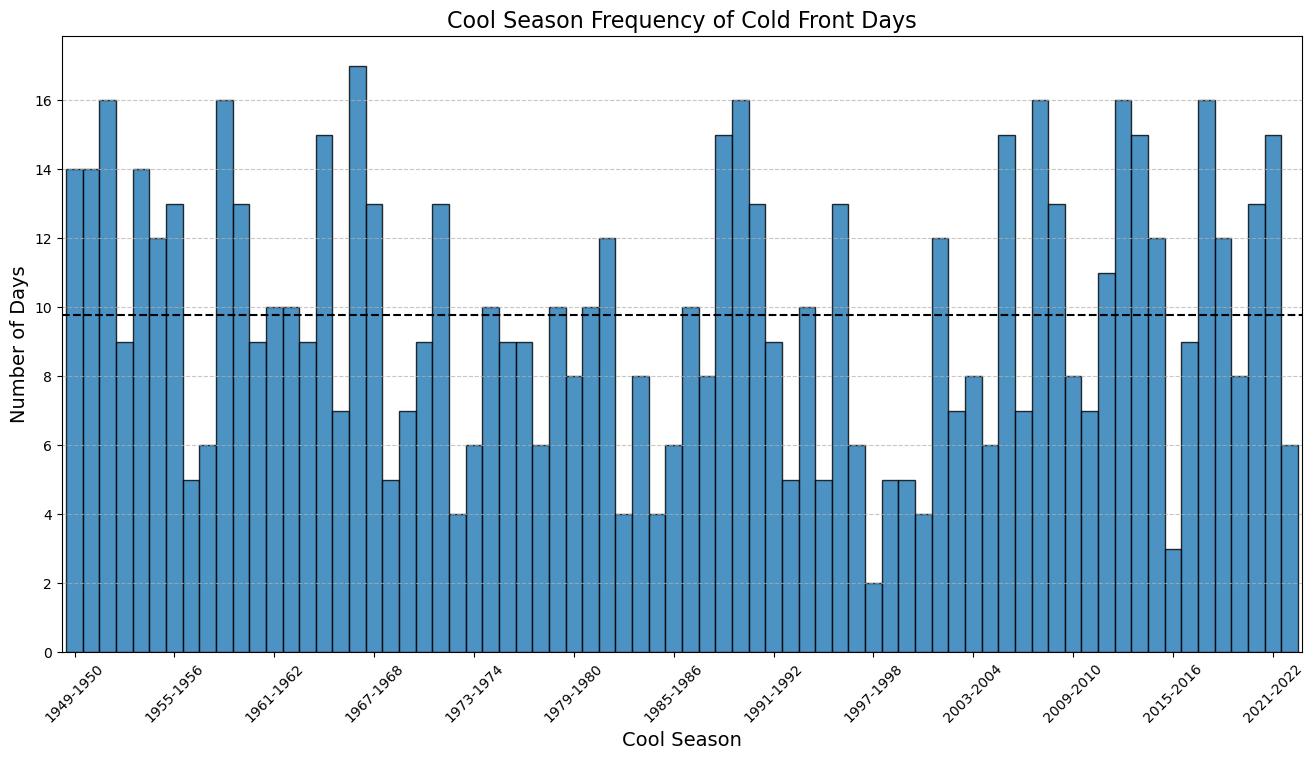

Average number of Non-NaN Cold Front Days per cool season: 9.77
Minimum number of Non-NaN Cold Front Days per cool season: 2.00
Maximum number of Non-NaN Cold Front Days per cool season: 17.00


In [23]:
###Cool Season Frequencies###

#Convert cftime.DatetimeGregorian objects to pandas Timestamps#
non_nan_days_pd = pd.to_datetime([str(date) for date in non_nan_days.values])  #change for all, LP, and HP

#Define a function to assign a cool season label to each date#
def assign_cool_season(date):
    
    year = date.year
    
    if date.month >= 9:
        return f"{year}-{year+1}"
    else:
        return f"{year-1}-{year}"

#Apply the function to assign season labels and count#
cool_season_labels = non_nan_days_pd.map(assign_cool_season)
cool_season_counts = pd.Series(cool_season_labels).value_counts().sort_index()

#Define the default color#
default_color = 'lightgrey'

#Define the colors for specific bars (let's say we want to highlight the 1986-1987 and 1987-1988 seasons)#
highlight_colors = {'1986-1987': 'orange', '1987-1988': 'green'}

#Create a list of colors to apply to each bar#
bar_colors = [highlight_colors.get(season, default_color) for season in cool_season_counts.index]

#Plotting#
plt.figure(figsize=(16, 8))
cool_season_counts.plot(kind='bar', edgecolor='black', alpha=0.8, width=1.0)

plt.title('Cool Season Frequency of Cold Front Days', fontsize=16)
plt.xlabel('Cool Season', fontsize=14)
plt.xticks(np.arange(0,75,6))
plt.ylabel('Number of Days', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate the x-ticks for better readability
plt.axhline(y = cool_season_counts.mean(), color = 'black', linestyle = '--') 

plt.show()

#Calculate the stats#
average_per_cool_season = cool_season_counts.mean()
min_per_cool_season = cool_season_counts.min()
max_per_cool_season = cool_season_counts.max()
print(f"Average number of Non-NaN Cold Front Days per cool season: {average_per_cool_season:.2f}")
print(f"Minimum number of Non-NaN Cold Front Days per cool season: {min_per_cool_season:.2f}")
print(f"Maximum number of Non-NaN Cold Front Days per cool season: {max_per_cool_season:.2f}")

Average for El Niño: 0.00 days
Average for La Niña: 0.00 days
Average for La Nada: 9.77 days
Median for El Niño: 0.00 days
Median for La Niña: 0.00 days
Median for La Nada: 9.00 days


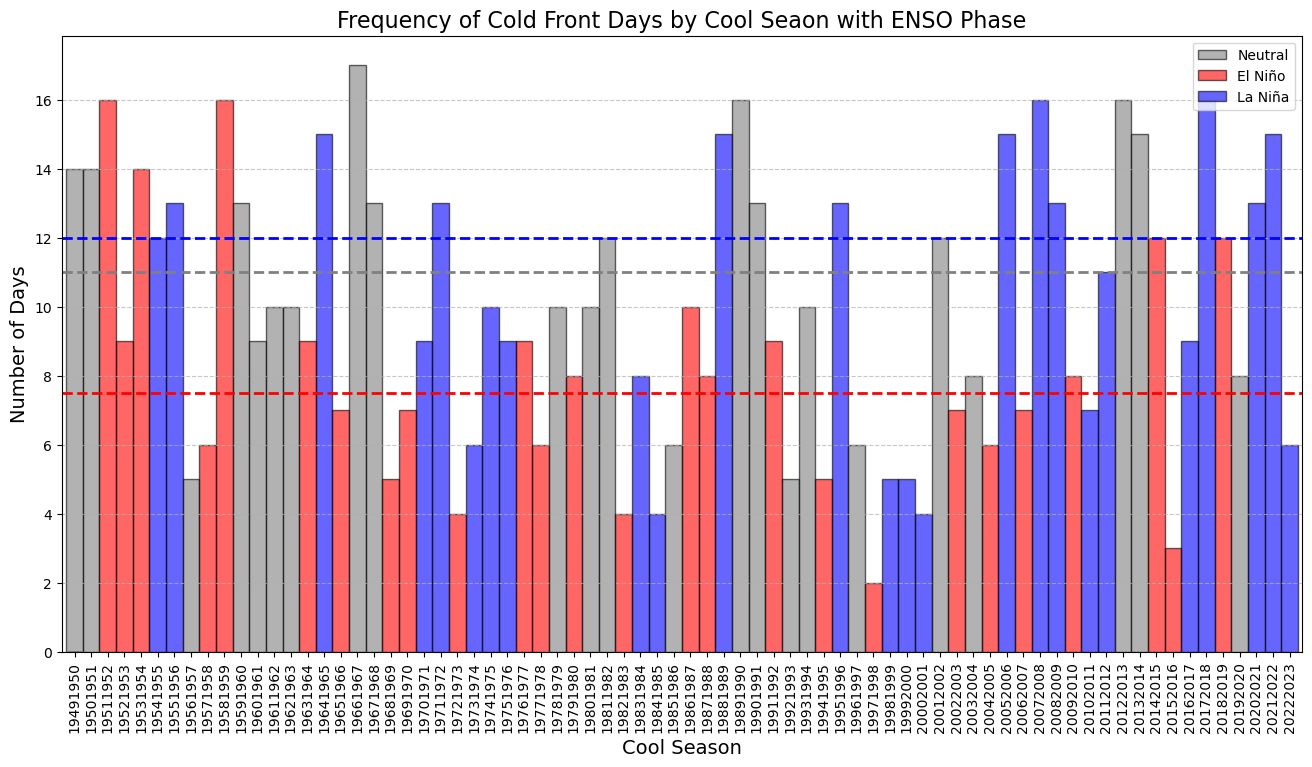

In [24]:
###Cool season freq ranked by ENSO###

el_nino_seasons = [
    '1951-52','1952-53', '1953-54', '1958-59', '1963-64', '1968-69', 
    '1969-70', '1976-77', '1977-78', '1979-80', '1986-87', 
    '1994-95', '2002-03', '2004-05', '2006-07', '2009-10', 
    '1957-58', '1965-66', '1972-73', '1987-88', '1991-92',
    '1982-83', '1997-98', '2014-15', '2015-16', '2018-19'
] 

la_nina_seasons = [
    '1954-55', '1964-65', '1971-72', '1974-75', '1983-84', '1984-85', '2000-01', '2005-06', '2008-09', '2016-17', '2017-18', '2022-23',
    '1955-56', '1970-71', '1995-96', '2011-12', '2020-21', '2021-22',
    '1973-74', '1975-76', '1988-89', '1998-99', '1999-00', '2007-08', '2010-11'
] 

##Find the means for each ENSO phase##

#Initialize empty dict#
enso_phases = {'El Niño': [], 'La Niña': [], 'La Nada': []}

#Loop through the cool seasons and assign the number of days to the correct ENSO phase#
for season, count in cool_season_counts.items():
    season_str = f"{season[:4]}-{season[6:]}"  # Adjust if necessary
    if season_str in el_nino_seasons:
        enso_phases['El Niño'].append(count)
    elif season_str in la_nina_seasons:
        enso_phases['La Niña'].append(count)
    else:
        enso_phases['La Nada'].append(count)

#Average for each ENSO phase#
enso_averages = {phase: sum(counts) / len(counts) if counts else 0 for phase, counts in enso_phases.items()}
enso_medians = {phase: np.median(counts) if counts else 0 for phase, counts in enso_phases.items()}

#Print the averages#
for phase, average in enso_averages.items():
    print(f"Average for {phase}: {average:.2f} days")

for phase, median in enso_medians.items():
    print(f"Median for {phase}: {median:.2f} days")   

#Now color based on ENSO#
cool_season_counts.index = cool_season_counts.index.str.replace('-', '')

#Color the bars#
bar_colors = []
for season in cool_season_counts.index:
    
    season_str = f"{season[:4]}-{season[6:]}"  #Get the cool season dates
    #print(season_str)
    
    if season_str in el_nino_seasons:
        bar_colors.append('red')
    elif season_str in la_nina_seasons:
        bar_colors.append('blue')
    else:
        bar_colors.append('grey')  #La Nada

#Plotting#
plt.figure(figsize=(16, 8))
cool_season_counts.plot(kind='bar', color=bar_colors, edgecolor='black', label='Neutral', alpha=0.6, width=1.0)

plt.title('Frequency of Cold Front Days by Cool Seaon with ENSO Phase', fontsize=16)
plt.xlabel('Cool Season', fontsize=14)
plt.ylabel('Number of Days', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)  # Rotate the x-ticks for better readability
plt.axhline(y = 7.5, color = 'red', linestyle = '--', linewidth=2) 
plt.axhline(y = 12, color = 'blue', linestyle = '--', linewidth=2) 
plt.axhline(y = 11, color = 'grey', linestyle = '--', linewidth=2) 
plt.yticks(np.arange(0,22,2))

plt.bar(0, 0, color='r', label='El Niño', edgecolor='black', alpha=0.6)
plt.bar(0, 0, color='b', label='La Niña', edgecolor='black', alpha=0.6)
plt.legend()

plt.show()

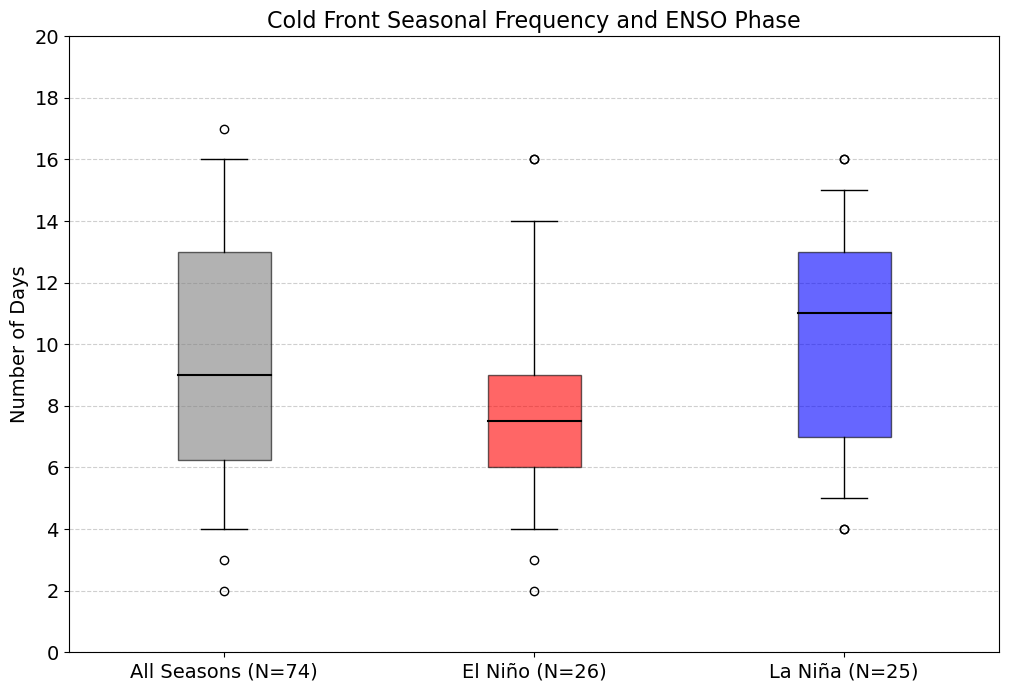

In [25]:
##Box and whisker plots for the 3 groupings##

#Function to change the format from 'YYYYYYYY' to 'YYYY-YY'#
def reformat_season_key(key):
    return f"{key[:4]}-{key[6:8]}"

#Create a new dictionary with the updated keys#
updated_cool_season_counts = {reformat_season_key(key): value for key, value in cool_season_counts.items()}

#Remove first and last item#
temp_list = list(updated_cool_season_counts.items())
#temp_list = temp_list[1:-1]  #comment this line to get full CF count
final_cs_counts = dict(temp_list)

#Separate the 3 groups#
all_seasons_data = list(final_cs_counts.values())
el_nino_data = [final_cs_counts[season] for season in el_nino_seasons if season in final_cs_counts]
la_nina_data = [final_cs_counts[season] for season in la_nina_seasons if season in final_cs_counts]

#Making the B&W plots#
data_to_plot = [all_seasons_data, el_nino_data, la_nina_data]
colors = ['grey', 'red', 'blue']

plt.figure(figsize=(12, 8))
bplot = plt.boxplot(data_to_plot, patch_artist=True, whis=(5,95), showfliers=True)

for median in bplot['medians']:
    median.set_color('black')
    median.set_linewidth(1.5)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

#plt.xlabel('Group', fontsize=14)
plt.ylabel('Number of Days', fontsize=14)
plt.title('Cold Front Seasonal Frequency and ENSO Phase', fontsize=16)
plt.xticks([1, 2, 3], [f'All Seasons (N={len(all_seasons_data)})', f'El Niño (N={len(el_nino_data)})', f'La Niña (N={len(la_nina_data)})'])
plt.yticks(np.arange(0,22,2))
plt.tick_params(labelsize=14)
#plt.legend([bplot["boxes"][0], bplot["boxes"][1], bplot["boxes"][2]], ['All Seasons', 'El Niño', 'La Niña'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

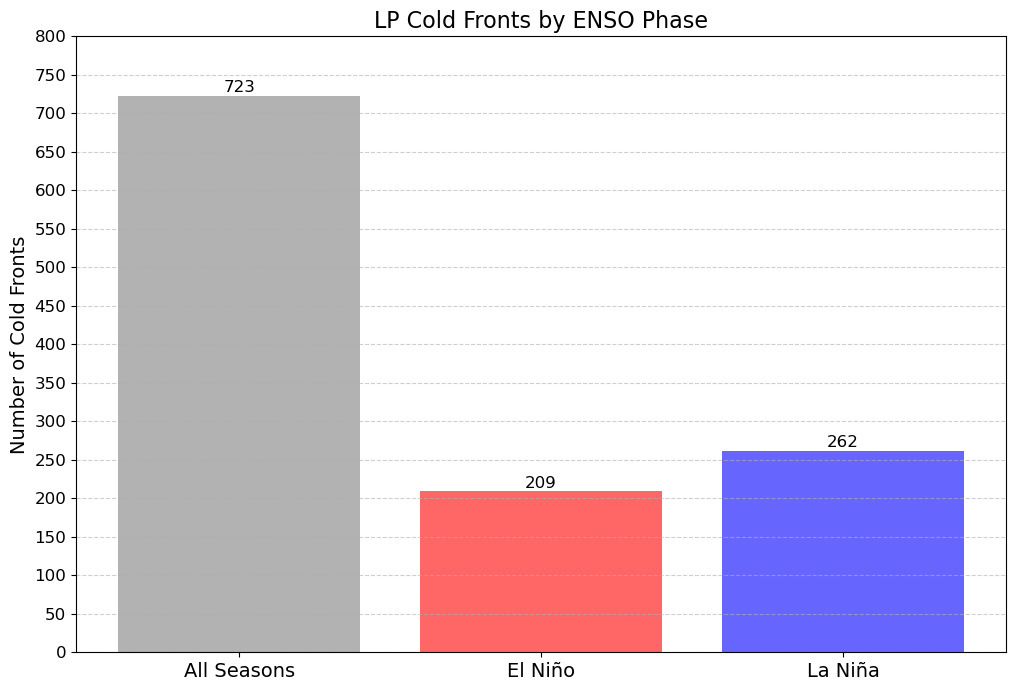

In [26]:
###Now remake this plot but make a bar chart for all the indidivual CF Cases###

#Sum the number of cold fronts for each group#
el_nino_total = sum(el_nino_data)
la_nina_total = sum(la_nina_data)
all_seasons_total = sum(all_seasons_data)

#Data for bar chart (total number of cold fronts per group)#
totals = [all_seasons_total, el_nino_total, la_nina_total]
labels = ['All Seasons', 'El Niño', 'La Niña']
colors = ['grey', 'red', 'blue']

#Plotting#
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, totals, color=colors, alpha=0.6)

plt.ylabel('Number of Cold Fronts', fontsize=14)
plt.title('LP Cold Fronts by ENSO Phase', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(np.arange(0, max(totals)+100, 50), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

#Display the N's on each bar#
for bar in bars:
    
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=12)
    
#plt.savefig("CF_Totals_LP.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

/tmp/ipykernel_2212622/3963436851.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cool_season_counts['ENSO'] = filtered_cool_season_counts['season'].apply(


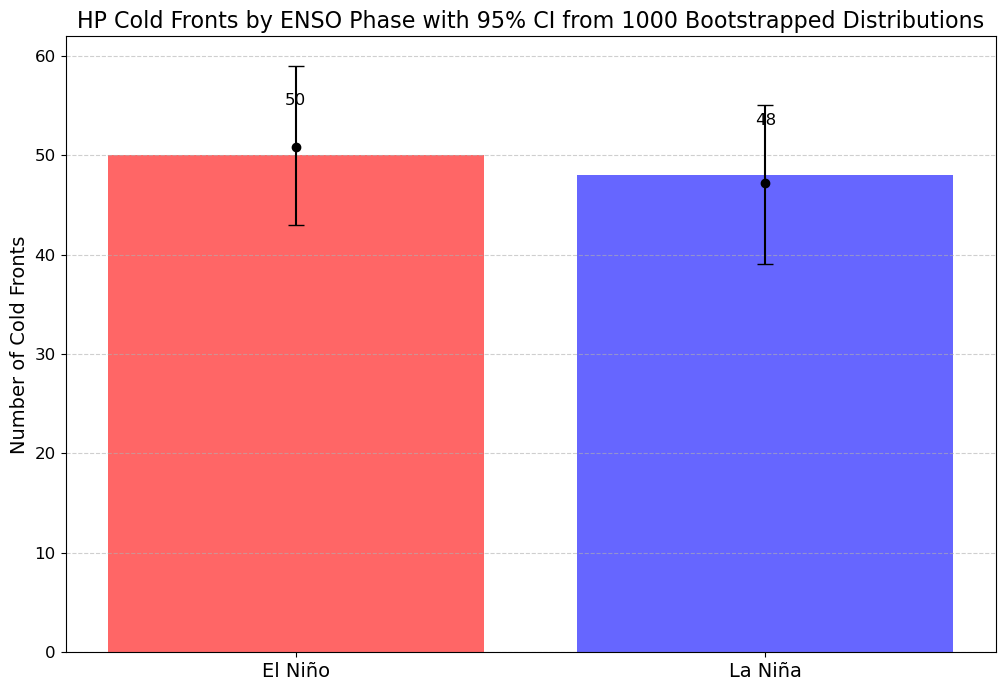

In [27]:
###Perform the statistical testing now###

#Your observed counts from ENSO groups#
ENSO_N = [50, 48]  #will need to change#
TOT_N = ENSO_N[0] + ENSO_N[1]

#Your bootstrapping setup#
n_bootstraps = 1000
n_samples = TOT_N     #Total days to sample in the bootstrap

#Generate the list of seasons from 1950-1951 to 2021-2022#
start_year = 1950
end_year = 2022
seasons = [f"{year}-{str(year+1)[-2:]}" for year in range(start_year, end_year)]

#Make it into a pandas df#
cool_season_counts = pd.DataFrame({
    'season': seasons,
    'count': 1     #Dummy value
})

#Filter out only El Niño and La Niña seasons#
filtered_cool_season_counts = cool_season_counts[
    cool_season_counts['season'].isin(el_nino_seasons + la_nina_seasons)
]

filtered_cool_season_counts['ENSO'] = filtered_cool_season_counts['season'].apply(
    lambda x: 'El Niño' if x in el_nino_seasons else 'La Niña'
)

#Perform bootstrap sampling#
bootstrap_distributions = []

for _ in range(n_bootstraps):
    
    #Randomly sample the days from the filtered dataset
    sampled_data = filtered_cool_season_counts.sample(n=n_samples, replace=True, weights='count')
    
    #Sum the occurrences in each ENSO phase#
    el_nino_sum = sampled_data[sampled_data['ENSO'] == 'El Niño']['count'].sum()
    la_nina_sum = sampled_data[sampled_data['ENSO'] == 'La Niña']['count'].sum()
    
    bootstrap_distributions.append([el_nino_sum, la_nina_sum])

#Convert bootstrap results to df#
bootstrap_df = pd.DataFrame(bootstrap_distributions, columns=['El Niño', 'La Niña'])

#Calculate 95% confidence intervalsE
ci_lower = bootstrap_df.quantile(0.05)
ci_upper = bootstrap_df.quantile(0.95)
ci_mean = bootstrap_df.mean()

#Plotting#
plt.figure(figsize=(12, 8))

#Plotting#
bars = plt.bar(['El Niño', 'La Niña'], ENSO_N, color=['red', 'blue'], alpha=0.6)

#Add error bars for 95% CI#
plt.errorbar(['El Niño', 'La Niña'], ci_mean, 
             yerr=[ci_mean - ci_lower, ci_upper - ci_mean], 
             fmt='o', color='black', capsize=6)

plt.ylabel('Number of Cold Fronts', fontsize=14)
plt.title('HP Cold Fronts by ENSO Phase with 95% CI from 1000 Bootstrapped Distributions', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

#Add the number of cold fronts on top of each bar#
for bar, label in zip(bars, ENSO_N):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(label), ha='center', fontsize=12)
    
#plt.savefig("CF_ENSO_BT_HP.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [28]:
###Write the ONI Text file to a CSV###

import csv
import re

#Open the text file for reading#
with open('/projects/zami4053/Synoptic_Research/Other_Data/detrend.nino34.ascii.txt', 'r') as textfile:
    #Open the CSV file for writing#
    with open('ONI.csv', 'w', newline='') as csvfile:
        #Create a writer object#
        csvwriter = csv.writer(csvfile)
        #csvwriter.writerow(['Year', 'Month', 'Total', 'Clim_Adjust', 'ONI_Index'])

        #Read the text file line by line#
        for line in textfile:
            #Strip leading/trailing whitespace and split the line into parts
            #Adjust the splitting logic to match your text file's format
            parts = re.split(r'\s+', line.strip())

            #Write the parts to the CSV file#
            csvwriter.writerow(parts)

In [29]:
###Figure out the ENSO stuff###

#Load the dataset
df = pd.read_csv('ONI.csv')

#Convert 'YR' and 'MON' to integers if they are not already#
df['YR'] = df['YR'].astype(int)
df['MON'] = df['MON'].astype(int)

#Assuming the cool season starts in October and ends in May next year#
cool_season_amplitude = {}

for year in range(1950, 2023):
    
    #Select the range from October this year to May next year#
    current_year = df[(df['YR'] == year) & (df['MON'] >= 10)]
    next_year = df[(df['YR'] == year + 1) & (df['MON'] <= 5)]
    season_data = pd.concat([current_year, next_year])

    #Find the maximum absolute anomaly to preserve the sign#
    max_anom = season_data.iloc[season_data['ANOM'].abs().argmax()]['ANOM']
    
    #Get the corresponding year and month for the max anomaly#
    max_anom_row = season_data.iloc[season_data['ANOM'].abs().argmax()]
    max_month = max_anom_row['MON']
    max_year = int(max_anom_row['YR'])  #Ensure max_year is an integer

    #Adjust the season identifier based on the month#
    if max_month <= 5:
        season = f"{max_year-1}-{str(max_year % 100).zfill(2)}"
        
    else:
        season = f"{year}-{str((year + 1) % 100).zfill(2)}"

    #Store the result
    cool_season_amplitude[season] = max_anom

#Remove the last item#
temp_list2 = list(cool_season_amplitude.items())
temp_list2 = temp_list2[:-1]
cool_season_amplitude_f = dict(temp_list2)

#Print the results
# for season, amplitude in cool_season_amplitude.items():
#     print(f"{season}: {amplitude}")

In [30]:
###Perform a super el nino event sensitivity###

#Exclude these 4 seasons#
exclude_seasons = ['1972-73', '1982-83', '1997-98', '2015-16']

filtered_amp_dict = {season: val for season, val in cool_season_amplitude_f.items() if season not in exclude_seasons}
filtered_cs_counts = {season: val for season, val in final_cs_counts.items() if season not in exclude_seasons}

len(filtered_amp_dict), len(filtered_cs_counts)

(68, 70)

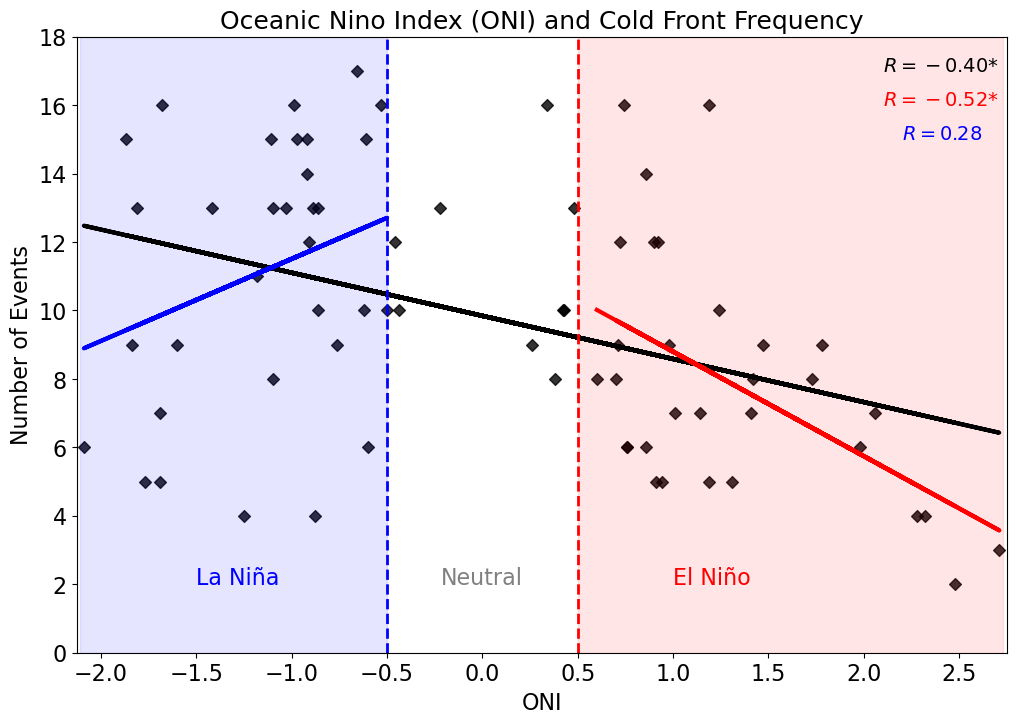

In [33]:
###Make a scatterplot of ONI vs year###

#Obtain ONI max amplitude for cool season#
amps = []
for season, amplitude in cool_season_amplitude_f.items():
    amps.append(amplitude)

#Obtain cool season CF frequencies#
CFcounts = []
for season, counts in final_cs_counts.items():
    CFcounts.append(counts)

#Convert to np arrays#
amps_ar = np.array(amps)
CFcounts_ar= np.array(CFcounts)[1:-1]   #exclude 1949 and 2023 since incomplete   

#Plot the figure#
plt.figure(figsize=(12, 8))

slope, intercept = np.polyfit(amps_ar, CFcounts_ar, 1)
y_pred = slope * amps_ar + intercept
r_value = np.corrcoef(amps_ar, CFcounts_ar)[0, 1]
r_sqr = np.corrcoef(amps_ar, CFcounts_ar)[0, 1] **2
plt.plot(amps_ar, y_pred, color='black', linewidth=3)
plt.text(2.1, np.max(CFcounts_ar), f'$R={r_value:.2f}$*', fontsize=14)
#plt.text(2.3, 16, f'$R^2 = {r_sqr:.2f}$', fontsize=12)

plt.scatter(amps, CFcounts_ar, color='black', alpha=0.8, marker='D')

##Now, isolate the El Niño subset where ONI Index > 0.5##
el_nino_mask = amps_ar >= 0.5
el_nino_amps = amps_ar[el_nino_mask]
el_nino_CFcounts = CFcounts_ar[el_nino_mask]

#Perform linear regression on the El Niño subset#
el_nino_slope, el_nino_intercept = np.polyfit(el_nino_amps, el_nino_CFcounts, 1)
el_nino_y_pred = el_nino_slope * el_nino_amps + el_nino_intercept

#Calculate the new correlation coefficient 'r' for the El Niño subset#
el_nino_r_value = np.corrcoef(el_nino_amps, el_nino_CFcounts)[0, 1]

#Plot the new trend line for the El Niño subset#
plt.plot(el_nino_amps, el_nino_y_pred, color='red', linestyle='-', linewidth=3)

#Add the new r value to the plot#
plt.text(2.1, np.max(CFcounts_ar)-1 , f'$R={el_nino_r_value:.2f}$*', fontsize=14, color='red')

##Now, isolate the La Nina subset where ONI Index < -0.5##
la_nina_mask = amps_ar <= -0.5
la_nina_amps = amps_ar[la_nina_mask]
la_nina_CFcounts = CFcounts_ar[la_nina_mask]

#Perform linear regression on the El Niño subset#
la_nina_slope, la_nina_intercept = np.polyfit(la_nina_amps, la_nina_CFcounts, 1)
la_nina_y_pred = la_nina_slope * la_nina_amps + la_nina_intercept

#Calculate the new correlation coefficient 'r' for the El Niño subset#
la_nina_r_value = np.corrcoef(la_nina_amps, la_nina_CFcounts)[0, 1]

#Plot the new trend line for the El Niño subset#
plt.plot(la_nina_amps, la_nina_y_pred, color='blue', linestyle='-', linewidth=3)

#Add the new r value to the plot#
plt.text(2.2, np.max(CFcounts_ar)-2 , f'$R={la_nina_r_value:.2f}$', fontsize=14, color='blue')

#Finishing plotting#
plt.title('Oceanic Nino Index (ONI) and Cold Front Frequency', fontsize=18)
plt.xlabel('ONI', fontsize=16)
plt.axvline(-0.5, color='blue', linestyle='dashed', linewidth=2)
plt.axvline(0.5, color='red', linestyle='dashed', linewidth=2)
plt.text(-1.5, 2, 'La Niña', color='blue', fontsize=16)
plt.text(1, 2, 'El Niño', color='red', fontsize=16)
plt.text(-0.22, 2, 'Neutral', color='grey', fontsize=16)
plt.xticks(np.arange(-2.5, 3, 0.5))
plt.yticks(np.arange(0, 19, 2))
plt.ylabel('Number of Events', fontsize=16)
plt.tick_params(labelsize=16)

#Shade the regions#
plt.margins(x=0.004)
xlim = plt.xlim()
plt.axvspan(0.5, xlim[1], color='red', alpha=0.1)
plt.axvspan(xlim[0], -0.5, color='blue', alpha=0.1)

plt.savefig("ONI_upd.png", dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [32]:
###Now perform statistical testing on the correlations for the ENSO plot###

#Make a function to carry out the statistical test#
def correlation_t_test(r_value, n):
    """
    Perform t-test to determine if the correlation coefficient is significantly different from zero.
    
    Parameters:
    - r_value: the sample correlation coefficient
    - n: the number of observations (sample size)
    
    Returns:
    - t_stat: the t-statistic
    - p_value: the two-tailed p-value
    """
    t_stat = r_value * np.sqrt((n - 2) / (1 - r_value**2))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))
    
    return t_stat, p_value

##Perform on the full and El Nino subsets##

##For the full dataset##
n = len(amps_ar)  
r_value_full = r_value.copy()

#Perform t-test for the full dataset#
t_stat_full, p_value_full = correlation_t_test(r_value_full, n)
print(f"Full dataset: t-statistic = {t_stat_full:.2f}, p-value = {p_value_full:.4f}")


##For the El Niño subset##
n_el_nino = len(el_nino_amps)  
r_value_el_nino = el_nino_r_value.copy() 

#Perform t-test for the El Niño subset#
t_stat_el_nino, p_value_el_nino = correlation_t_test(r_value_el_nino, n_el_nino)
print(f"El Niño subset: t-statistic = {t_stat_el_nino:.2f}, p-value = {p_value_el_nino:.4f}")


##For the La Nina subset##
n_la_nina = len(la_nina_amps)  
r_value_la_nina = la_nina_r_value.copy() 

#Perform t-test for the El Niño subset#
t_stat_la_nina, p_value_la_nina = correlation_t_test(r_value_la_nina, n_la_nina)
print(f"La Nina subset: t-statistic = {t_stat_la_nina:.2f}, p-value = {p_value_la_nina:.4f}")

#Interpret the results#
if p_value_full < 0.05:
    print("The correlation for the full dataset is significantly different from zero.")
else:
    print("The correlation for the full dataset is not significantly different from zero.")

if p_value_el_nino < 0.05:
    print("The correlation for the El Niño subset is significantly different from zero.")
else:
    print("The correlation for the El Niño subset is not significantly different from zero.")
    
if p_value_la_nina < 0.05:
    print("The correlation for the La Nina subset is significantly different from zero.")
else:
    print("The correlation for the La Nina subset is not significantly different from zero.")

Full dataset: t-statistic = -3.69, p-value = 0.0004
El Niño subset: t-statistic = -3.24, p-value = 0.0030
La Nina subset: t-statistic = 1.58, p-value = 0.1244
The correlation for the full dataset is significantly different from zero.
The correlation for the El Niño subset is significantly different from zero.
The correlation for the La Nina subset is not significantly different from zero.
